# Tree based methods

In [2]:
# imports
import pandas as pd
import numpy as np
from utils import import_and_transform
from utils import evaluate_model

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier


## Import data and apply transformations

In [8]:
raw_data = pd.read_parquet("Data/train.parquet")

In [9]:
user_data = import_and_transform(raw_data)

Using Dataframe


In [14]:
user_data.head(1)

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,...,userAgent,method,length,song,artist,time,registration,churned,session_length,song_played
0,200,1,Shlok,1,Johnson,1749042,2018-10-01 00:00:01,Logged In,NextSong,22683,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,1,11405.0,1


## Aggregate data

In [16]:
def aggregate(data: pd.DataFrame):
    user_df = df.groupby('userId').agg({
        'gender': 'first',
        'registration': 'first',
        'level': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'sessionId': 'nunique',
        'itemInSession': 'max',
        'ts': ['min', 'max'],
        'session_length': 'mean',
        'song_played': 'sum',
        'artist': pd.Series.nunique,
        'length': 'sum',
        'churned': 'max'    
    }).reset_index()
    
    user_df.columns = ['userId', 'gender', 'registration', 'level',
                       'num_sessions', 'max_item_in_session', 'ts_min', 'ts_max', 
                       'avg_session_length_seconds',  # Renamed for clarity
                       'num_songs_played', 'unique_artists', 'total_length', 'churned']
    
    user_df['days_active'] = (user_df['ts_max'] - user_df['ts_min']).dt.days
    user_df['membership_length'] = (user_df['ts_max'] - user_df['registration']).dt.days
    
    user_df = user_df.fillna(0)
    
    print(f"Processed {len(user_df)} users")
    print(f"Churn rate: {user_df['churned'].mean():.2%}")

    final_column_order = [
            'userId', 'gender', 'registration', 'level',
            'num_sessions', 'max_item_in_session', 'ts_min', 'ts_max',
            'avg_session_length_seconds', 'num_songs_played',
            'unique_artists', 'total_length', 'days_active',
            'membership_length', 'churned'
        ]
    
        
    user_df = user_df[final_column_order]
    user_df.set_index('userId', inplace=True)

    return user_df

In [41]:
user_data.drop(columns=['registration', 'ts_min', 'ts_max'], inplace=True)

X = user_data.drop(columns='churned')
y = user_data['churned']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [53]:
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# 6. Evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.8085161964472309

Confusion Matrix:
 [[2490  484]
 [ 249  605]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      2974
           1       0.56      0.71      0.62       854

    accuracy                           0.81      3828
   macro avg       0.73      0.77      0.75      3828
weighted avg       0.83      0.81      0.82      3828



In [43]:
test_df = import_and_transform('Data/test.parquet')
test_df.drop(columns='churned', inplace=True)
test_df.drop(columns=['registration', 'ts_min', 'ts_max'], inplace=True)
test_df.set_index('userId', inplace=True)


Processed 2904 users
Churn rate: 0.00%


In [44]:
predictions = clf.predict(test_df)
user_ids = test_df.index  # get index as user IDs


# === 5. Create submission DataFrame ===
submission = pd.DataFrame({
    "id": user_ids,
    "target": predictions
})

# === 6. Export to CSV ===
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")



✅ submission.csv saved!


In [49]:
import xgboost as xgb
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_ratio = neg / pos

clf = xgb.XGBClassifier(
    scale_pos_weight=scale_ratio,  # handles imbalance
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Assume test_df has same features, userId as index
X_new = test_df.drop(columns=[], errors='ignore')  # drop target if exists
user_ids = test_df.index

y_new_pred = clf.predict(X_new)

submission = pd.DataFrame({
    'id': user_ids,
    'target': y_new_pred
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved")

Confusion Matrix:
 [[2544  430]
 [ 203  651]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89      2974
           1       0.60      0.76      0.67       854

    accuracy                           0.83      3828
   macro avg       0.76      0.81      0.78      3828
weighted avg       0.85      0.83      0.84      3828

F1 Score: 0.6728682170542636
✅ submission.csv saved


C:\Users\Martin\Documents\X HEC\env\lib\site-packages\xgboost\training.py:199: UserWarning: [15:51:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


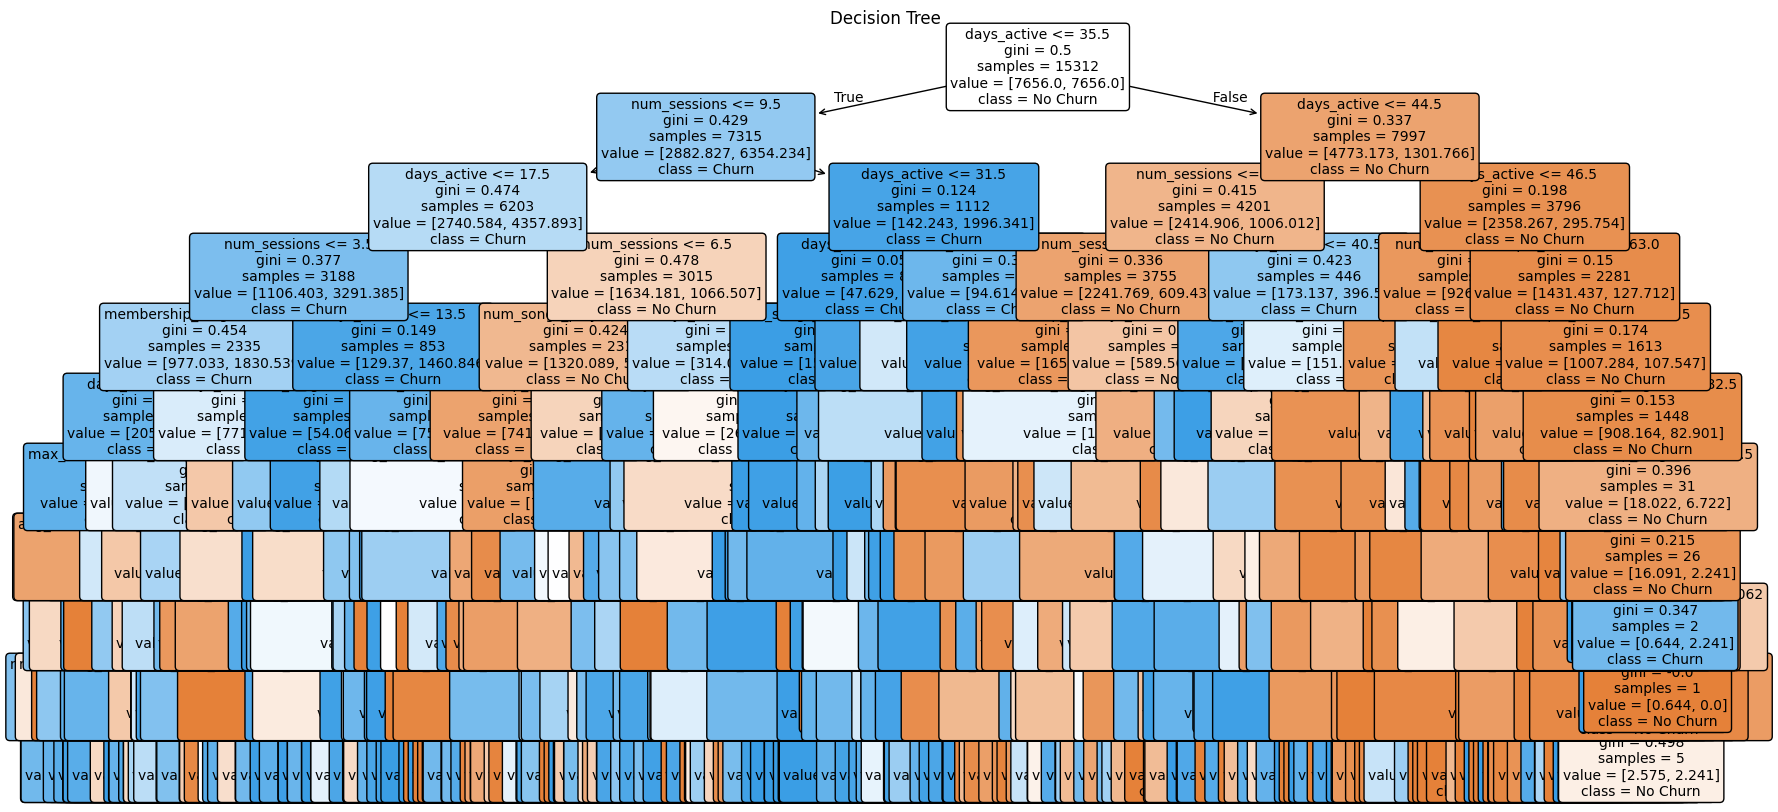

In [54]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    clf,                        # your trained DecisionTreeClassifier
    feature_names=X_train.columns,
    class_names=["No Churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree")
plt.show()